# Protein embeddings improve phage-host interaction prediction

**Mark Edward M. Gonzales<sup>1, 2</sup>, Jennifer C. Ureta<sup>1, 2</sup> & Anish M.S. Shrestha<sup>1, 2</sup>**

<sup>1</sup> Bioinformatics Laboratory, Advanced Research Institute for Informatics, Computing and Networking, De La Salle University, Manila, Philippines <br>
<sup>2</sup> Department of Software Technology, College of Computer Studies, De La Salle University, Manila, Philippines 

{mark_gonzales, jennifer.ureta, anish.shrestha}@dlsu.edu.ph

<hr>

## 💡 Phage-Host-Features CSV Files

This notebook assumes that you already have the phage-host-features CSV files (from running [`5. Data Consolidation.ipynb`](https://github.com/bioinfodlsu/phage-host-prediction/blob/main/experiments/5.%20Data%20Consolidation.ipynb)).

Alternatively, you may download the CSV files from [Google Drive](https://drive.google.com/drive/folders/1xNoA6dxkN4jzVNCg_7YNjdPZzl51Jo9M?usp=sharing) and save the downloaded `data` folder inside the `inphared` directory located in the same folder as this notebook. The folder structure should look like this:

`experiments` (parent folder of this notebook) <br> 
↳ `inphared` <br>
&nbsp; &nbsp;↳ `data` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp.csv` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp_embeddings_esm.csv` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ ... <br>
↳ `6.1. Further Model Evaluation (Specificity + PR Curve).ipynb` (this notebook) <br>

<hr>

## Part I: Preliminaries

Import the necessary libraries and modules.

In [115]:
import math
import pickle
import os
import warnings

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from imblearn.metrics import specificity_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc

from ConstantsUtil import ConstantsUtil
from ClassificationUtil import ClassificationUtil
import boeckaerts as RBP_f

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)

pd.options.mode.chained_assignment = None

with warnings.catch_warnings(): 
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [4]:
constants = ConstantsUtil()
util = ClassificationUtil()

<hr>

## Part II: Measuring Specificity

Load the pickled files storing the results of evaluating the performance of the models.

In [6]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))

Declare constant variables for readability of subsequent code.

In [211]:
CLASS = 0
MICRO = 1
MACRO = 2
WEIGHTED = 3

PRECISION = 0
RECALL = 1

Y_TEST = -3
Y_PRED = -1

The shaded cells in the subsequent tables correspond to the highest scores (i.e., best performance in terms of the specified evaluation metric).

### Protein Language Models vs Handcrafted

In [37]:
results = []
for model in models:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[models.index(model)][threshold][Y_TEST]
        y_pred = model_results[models.index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)

print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = models)
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
PROTTRANSBERT,96.89%,96.78%,96.34%,95.83%,95.31%,94.78%,94.08%,93.36%,92.59%,91.64%,89.91%
PROTXLNET,96.82%,96.62%,96.12%,95.64%,95.20%,94.67%,94.04%,93.26%,92.50%,91.52%,89.85%
PROTTRANSALBERT,96.84%,96.76%,96.22%,95.68%,95.20%,94.70%,94.08%,93.30%,92.50%,91.57%,89.82%
PROTT5,97.26%,97.14%,96.60%,96.12%,95.61%,95.08%,94.44%,93.66%,92.93%,91.87%,89.93%
ESM,97.20%,97.00%,96.49%,96.02%,95.54%,95.05%,94.33%,93.60%,92.83%,91.82%,89.96%
ESM1B,97.33%,97.07%,96.61%,96.07%,95.57%,95.01%,94.35%,93.60%,92.83%,91.81%,89.94%
SEQVEC,96.63%,96.65%,96.19%,95.71%,95.24%,94.73%,94.06%,93.29%,92.56%,91.56%,89.76%
BOECKAERTS,96.76%,96.81%,96.32%,95.77%,95.17%,94.58%,93.89%,93.10%,92.36%,91.41%,89.61%


In [35]:
print("Weighted Specificity per Class")
print("\n============\n")

for threshold in range(0, 11):
    print('Confidence threshold k:', str(threshold * 10) + '%')
    y_test = model_results[models.index(model)][threshold][Y_TEST]
    y_pred = model_results[models.index(model)][threshold][Y_PRED]
    print(specificity_score(y_test, y_pred, average=None))
    print("\n============\n")

Weighted Specificity per Class


Confidence threshold k: 0%
[1.         0.99987528 0.99962598 1.         1.         0.99140546
 1.         1.         0.99888572 0.99724725 0.99950562 0.99888641
 0.99740484 0.99938119 0.99975198 1.         0.99360421 0.99975208
 0.99144317 0.84342472 0.99962816 0.99764356 0.9977786  1.
 0.98821091 0.99975327 0.99975287 0.999002   1.         0.99975272
 0.99950513 0.99656838 1.         0.99962963 0.9992542  0.99826797
 1.         0.99913194 0.99938088 0.99975309 1.         0.95107195
 0.99987615 1.         0.99875653 0.9996288  1.         0.99171566
 0.99862826 1.         0.99598645 0.98716972 0.99975232 0.99900436
 0.99900904 0.98788677 0.98353587 0.9992554  0.99638539]


Confidence threshold k: 10%
[1.         1.         0.99975065 1.         1.         0.99747219
 1.         1.         0.99975238 0.99887387 1.         0.99938134
 0.99777558 0.99950495 1.         1.         0.99586155 0.99975208
 0.99821201 0.94311685 1.         0.99975195 0.99814883 1

### Global: ProtT5 + Handcrafted (Individually)

In [40]:
model_results = []
important_features = ['A_freq', 'GC', 'C_freq', 'TTA', 'TTA_b']
for model in important_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [43]:
results = []
for model in important_features[:5]:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[important_features[:5].index(model)][threshold][Y_TEST]
        y_pred = model_results[important_features[:5].index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = important_features[:5])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
A_freq,97.38%,97.20%,96.67%,96.17%,95.70%,95.17%,94.51%,93.76%,93.00%,91.90%,89.93%
GC,97.31%,97.21%,96.70%,96.21%,95.72%,95.21%,94.57%,93.80%,93.01%,91.97%,90.01%
C_freq,97.27%,97.18%,96.73%,96.21%,95.74%,95.24%,94.53%,93.78%,92.99%,91.92%,89.95%
TTA,97.31%,97.13%,96.60%,96.13%,95.64%,95.13%,94.48%,93.67%,92.90%,91.87%,89.94%
TTA_b,97.28%,97.13%,96.62%,96.14%,95.60%,95.12%,94.47%,93.67%,92.89%,91.86%,89.92%


### Protein Features Only: ProtT5 + Handcrafted (Individually)

In [46]:
model_results = []
important_protein_features = ['K', 'pI', 'Z4', 'CTDC2', 'mol_weight']
for model in important_protein_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [48]:
results = []
for model in important_protein_features[:5]:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[important_protein_features[:5].index(model)][threshold][Y_TEST]
        y_pred = model_results[important_protein_features[:5].index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = important_features[:5])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
A_freq,97.22%,97.13%,96.62%,96.16%,95.64%,95.12%,94.44%,93.65%,92.94%,91.89%,89.94%
GC,97.20%,97.13%,96.60%,96.13%,95.61%,95.09%,94.43%,93.63%,92.91%,91.86%,89.98%
C_freq,97.18%,97.13%,96.58%,96.14%,95.66%,95.11%,94.43%,93.64%,92.88%,91.87%,89.94%
TTA,97.20%,97.14%,96.62%,96.14%,95.63%,95.13%,94.42%,93.67%,92.90%,91.85%,89.99%
TTA_b,97.22%,97.12%,96.58%,96.14%,95.65%,95.07%,94.45%,93.68%,92.91%,91.85%,89.96%


### Global: ProtT5 + Handcrafted (Top n)

In [49]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [58]:
results = []
for i in range(1, 6):
    result = []
    for threshold in range(0, 11):
        y_test = model_results[i - 1][threshold][Y_TEST]
        y_pred = model_results[i - 1][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')

    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = [i for i in range(1, 6)])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
1,97.22%,97.13%,96.62%,96.16%,95.64%,95.12%,94.44%,93.65%,92.94%,91.89%,89.94%
2,97.27%,97.17%,96.63%,96.13%,95.65%,95.09%,94.45%,93.67%,92.91%,91.86%,89.96%
3,97.19%,97.14%,96.63%,96.14%,95.61%,95.11%,94.44%,93.65%,92.86%,91.87%,89.97%
4,97.19%,97.14%,96.62%,96.17%,95.66%,95.11%,94.45%,93.67%,92.90%,91.91%,89.98%
5,97.22%,97.09%,96.64%,96.14%,95.62%,95.10%,94.41%,93.69%,92.92%,91.86%,89.92%


### Protein Features Only: ProtT5 + Handcrafted (Top n)

In [54]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_protein_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [59]:
results = []
for i in range(1, 6):
    result = []
    for threshold in range(0, 11):
        y_test = model_results[i - 1][threshold][Y_TEST]
        y_pred = model_results[i - 1][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)

        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = [i for i in range(1, 6)])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
1,97.22%,97.13%,96.62%,96.16%,95.64%,95.12%,94.44%,93.65%,92.94%,91.89%,89.94%
2,97.27%,97.17%,96.63%,96.13%,95.65%,95.09%,94.45%,93.67%,92.91%,91.86%,89.96%
3,97.19%,97.14%,96.63%,96.14%,95.61%,95.11%,94.44%,93.65%,92.86%,91.87%,89.97%
4,97.19%,97.14%,96.62%,96.17%,95.66%,95.11%,94.45%,93.67%,92.90%,91.91%,89.98%
5,97.22%,97.09%,96.64%,96.14%,95.62%,95.10%,94.41%,93.69%,92.92%,91.86%,89.92%


<hr>

## Part II: Plotting the PR Curve

In [242]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

# len(models) - 1 to exclude benchmark model
for i in range(len(models) - 1):        
    util.classify_more_thresholds(models[i], save_feature_importance)

Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished
Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished
Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished
Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished
Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished
Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished
Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished


In [248]:
rbp_embeddings = pd.read_csv(f'{constants.INPHARED}/{constants.DATA}/{constants.PLM_EMBEDDINGS_CSV["BOECKAERTS"]}',
                             low_memory = False)
features = rbp_embeddings.columns
features = features[constants.INPHARED_EXTRA_COLS:]

util.classify_more_thresholds(models[-1], feature_columns = list(features))

Constructing training and test sets...
Training the model...
Saving evaluation results...
Finished


In [281]:
models = ['SEQVEC', 'ESM', 'ESM1B', 'PROTTRANSBERT', 'PROTXLNET', 'PROTTRANSALBERT', 'PROTT5', 'BOECKAERTS']

model_results = []
for model in models:
    with open(constants.PLM_RESULTS_MORE_THRESHOLDS[model], 'rb') as f:
        model_results.append(pickle.load(f))

In [282]:
results_precision = []
for model in models:
    result = []
    for threshold in range(0, 101):
        metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
results_recall = []
for model in models:
    result = []
    for threshold in range(0, 101):
        metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

In [283]:
for model, precision, recall in zip(models, results_precision, results_recall):
    precision.reverse()
    recall.reverse()
    
    ave_precision = 0
    for i in range(1, len(precision)):
        ave_precision += (recall[i] - recall[i - 1]) * precision[i]
        
    print(model, ave_precision)

SEQVEC 0.3666030041070624
ESM 0.36607225873140486
ESM1B 0.3710607412946449
PROTTRANSBERT 0.36117182364137407
PROTXLNET 0.35493682324531195
PROTTRANSALBERT 0.36204247168969
PROTT5 0.3733790877326551
BOECKAERTS 0.3849190205792663


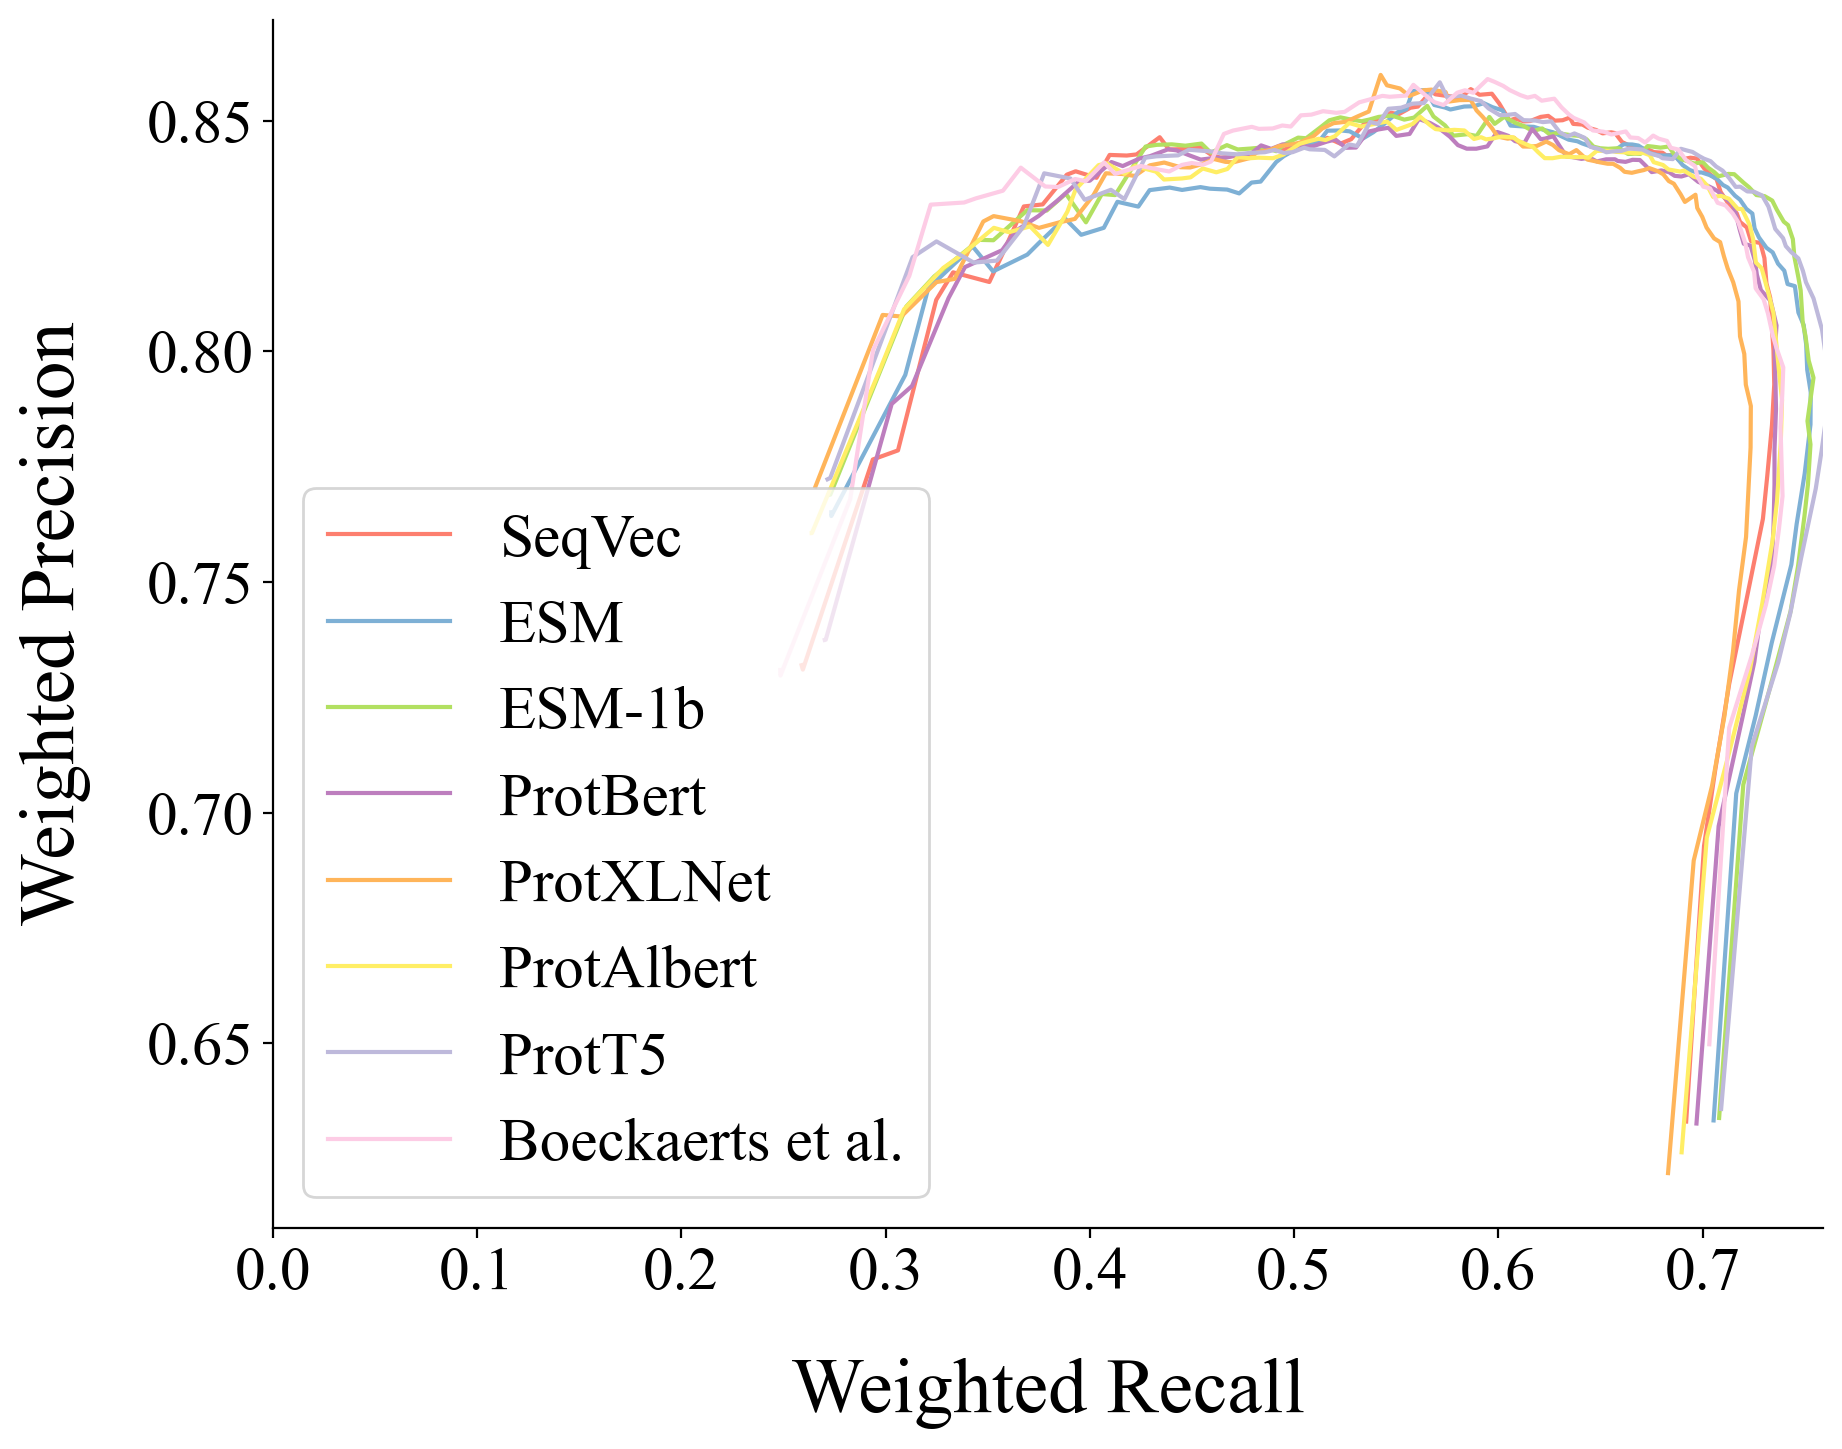

In [292]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10,8), dpi=200)

colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]
for i in range(0, len(models)):
    ax.plot(results_recall[i], results_precision[i], color = colors[i])
    ax.set_xlim(xmin=0)

ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.legend(['SeqVec', 'ESM', 'ESM-1b', 'ProtBert', 'ProtXLNet', 'ProtAlbert', 'ProtT5', 'Boeckaerts et al.'])